In [203]:
import gc
import numpy as np
import pandas as pd
import yfinance as yf
import back_testing as bt
import matplotlib.pyplot as plt

gc.collect()

4117

In [204]:
weight_df = pd.read_csv('data/weight_df.csv', index_col=0)
tic_df = pd.read_csv('data/tic_df.csv', index_col=0)
returns_df = pd.read_csv('data/returns_df.csv', index_col=0).loc[weight_df.index]
returns_df.index = pd.to_datetime(returns_df.index)
weight_df.index = pd.to_datetime(weight_df.index)
equal_weight_df = pd.DataFrame(1 / len(weight_df.columns), index=weight_df.index, columns=weight_df.columns)

weight_dict={}
weight_dict['Equal'] = equal_weight_df
weight_dict['Dynamic'] = weight_df

설정:
  - 기본 수수료: 10bp
  - Turnover 배수: 1
  - 리밸런싱 주기: A


[*********************100%***********************]  1 of 1 completed


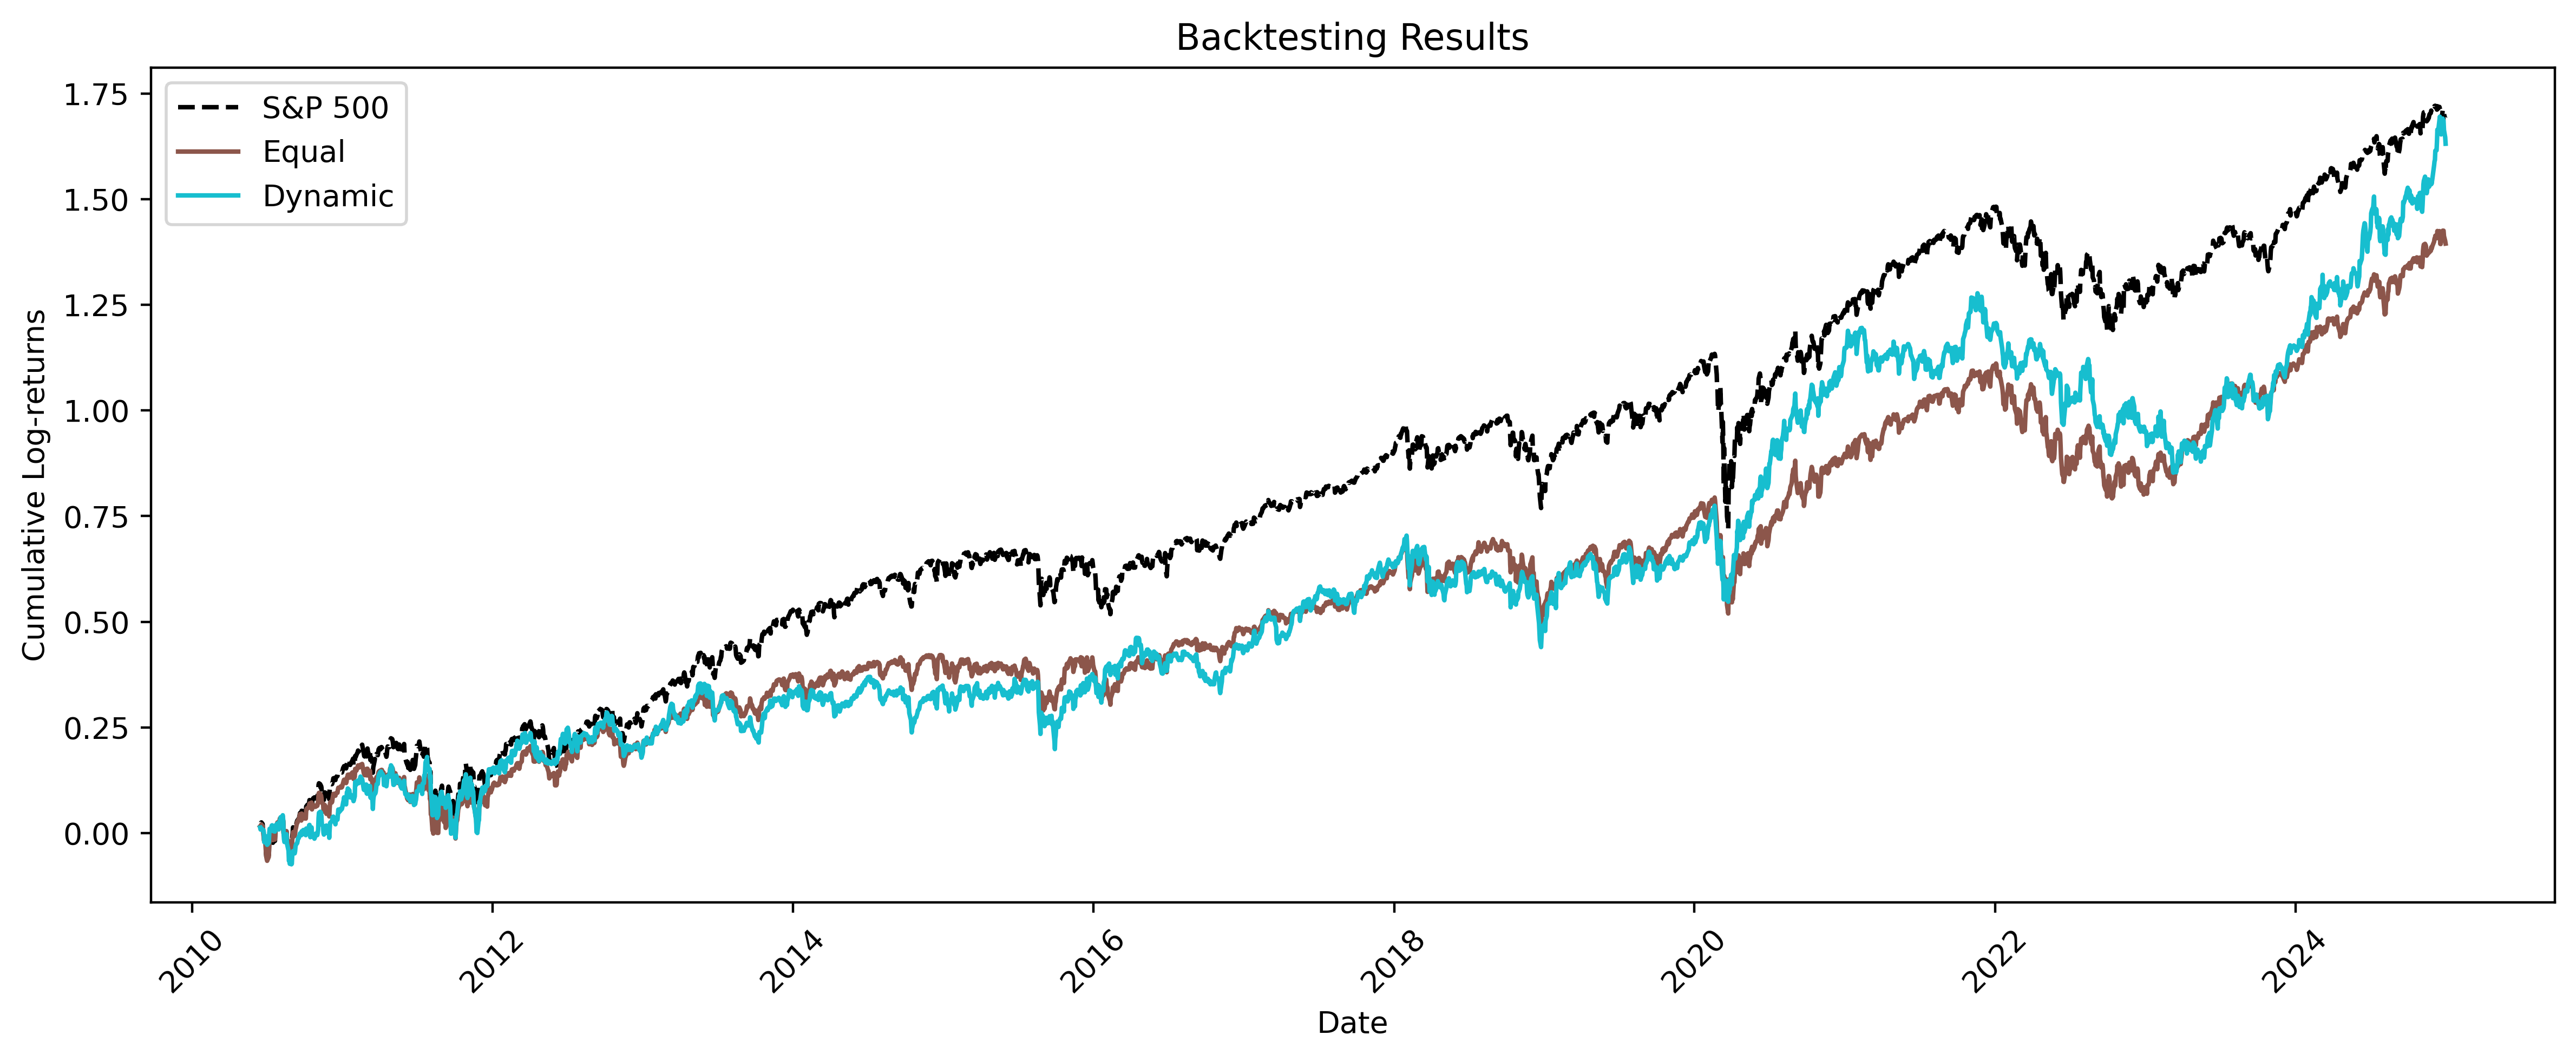

In [205]:
# 백테스팅 설정
base_fee = 0.001  # 기본 수수료 0.2%
turnover_multiplier = 1  # turnover에 따른 수수료 증가 배수
rebalance_freq = 'A' # 적응형 리벨런싱 주기

print(f"설정:")
print(f"  - 기본 수수료: {base_fee*10000:.0f}bp")
print(f"  - Turnover 배수: {turnover_multiplier}")
print(f"  - 리밸런싱 주기: {rebalance_freq}")

# 백테스팅 실행
result_df = pd.DataFrame()
for str_name in weight_dict.keys():

    result_df = bt.return_Table(
        weight_dict[str_name], 
        returns_df,  # 가격 데이터 직접 전달
        result_df,
        rebalance_freq=rebalance_freq,
        fee=base_fee,
        turnover_multiplier=turnover_multiplier,
        tic_df=tic_df
    )
    
# 컬럼명 설정 (S&P 500 + 전략들)
result_df.columns = ['S&P 500'] + list(weight_dict.keys())

bt.plot_result(result_df)

In [206]:
out = bt.compute_turnover_and_fee(base_fee, turnover_multiplier, weight_dict['Equal'], 'A', tic_df)
print(f"Equal: {out['turnover'].mean():.4f}")
print(f"Equal: {out['fee_log'].sum():.4f}")

out = bt.compute_turnover_and_fee(base_fee, turnover_multiplier, weight_dict['Dynamic'], 'A', tic_df)
print(f"Dynamic: {out['turnover'].mean():.4f}")
print(f"Dynamic: {out['fee_log'].sum():.4f}")

Equal: 0.0022
Equal: -0.1400
Dynamic: 0.0425
Dynamic: -0.3551


In [207]:
metric = bt.METRICS(result_df.dropna())
metric.cal_describe()
metric.cal_monthly_statistics()

In [208]:
metric.annual_statistics

,S&P 500,Equal,Dynamic
Date,2010-06-15 ~ 2024-12-31,2010-06-15 ~ 2024-12-31,2010-06-15 ~ 2024-12-31
count,3662,3662,3662
cumulative return,442.10511,304.99382,409.93269
annualized return mean,0.12335,0.10104,0.11863
annualized return std,0.18747,0.16965,0.20346
annualized return downside std,0.15372,0.12819,0.14383
sharpe ratio,0.65798,0.59556,0.58307
sortino ratio,0.80243,0.78815,0.82483
gross profit,13.95217,13.52363,16.42311
gross loss,-12.26188,-12.12493,-14.79401


In [209]:
metric.monthly_statistics

,S&P 500,Equal,Dynamic
Mean,0.00046,0.00038,0.00044
Standard deviation,0.01082,0.00987,0.01167
Standard error,0.00018,0.00016,0.00019
t-statistic,2.8011,2.525,2.4529
Min,-0.12765,-0.04854,-0.04988
25%,-0.00377,-0.00403,-0.00547
50%,0.00067,0.00066,0.00072
75%,0.00565,0.00559,0.00698
Max,0.08968,0.04561,0.04797
Skew,-0.74751,-0.38187,-0.25945


In [210]:
metric.save_results('./general_results')

In [211]:
subperiod_df = pd.DataFrame()
for period in [('2010-07-07', '2013-12-31'), ('2014-01-01', '2015-12-31'), ('2016-01-01', '2019-12-31'),\
    ('2020-01-01', '2022-12-31'), ('2023-01-01', '2024-12-31')]:
    metric.cal_describe(period)
    subperiod_df = pd.concat([subperiod_df, metric.annual_statistics.loc[['Date', 'annualized return mean', 'sharpe ratio', 'sortino ratio', 'maximum drawdown', 'calmar ratio']]], axis=0)

In [212]:
subperiod_df.to_csv('./general_results/subperiod_df.csv')